In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
import time
import numpy as np
sys.path.append(os.path.join(os.path.abspath(""), ".."))

import matplotlib.pyplot as plt

In [3]:
from app.utils import ImageWrapper
from app.models import Classifier
from app.custom import RemoveBusBars, Orient
from app.transforms import FFT, IFFT, CreateOnesMask, PCA
from app.filters import CreateKernel, Convolve, Canny, HOG
from app.imager import ImageLoader, DefectViewer, Show, Exposure
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
## Utility function:
def variance_plot(explained_var_ratio, n_components, pct = True):
    """Helper function to plot the captured variance"""
    
    # Define X axis intervals:
    x=np.arange(1, n_components + 1)
    # Cumulative variance:
    if pct:
        y1 = explained_var_ratio * 100
    else:
        y1 = explained_var_ratio
    y2 = np.cumsum(y1)
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()
    ax1.bar(x, y1, color = 'g')
    ax2.plot(x, y2, color = 'b')
    
    ax1.set_xlabel('Principal Component Number')
    ax1.set_xticks(x)
    
    if pct:
        ax1.set_ylabel('Explained Variance %', color='g')
        ax2.set_ylabel('Cumlative Explained Variance %', color='b')
    else:
        ax1.set_ylabel('Explained Variance', color='g')
        ax2.set_ylabel('Cumlative Explained Variance', color='b')
        
def plot_gallery(images, h=0, w=0, n_row=4, n_col=5):
    """Helper function to plot a gallery of portraits
       Adapted from https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_eigenfaces.html
    """
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        if h !=-0:
            plt.imshow(images[i].reshape((h, w)), cmap='Greys_r')
        else:
            plt.imshow(images[i], cmap='Greys_r')
        plt.title(f'Eigenface_{i+1}', size=12)
        plt.xticks(())
        plt.yticks(())

def get_n_samples(n_samples):
    
    closed = (DefectViewer() << (ImageLoader(defect_class='Corrosion') << n_samples))
    closed.category = 'Corrosion'
    clean = (DefectViewer() << (ImageLoader(defect_class='None') << n_samples))
    clean.category = 'Clean'
    all_others = (DefectViewer() << (ImageLoader(defect_class=['Resistive', 'Isolated', 'Closed', 'FrontGridInterruption', 'BrightSpot', 'NearSolderPad']) << n_samples))
    all_others.category = 'all_others'
    
    closed_ = closed.copy()
    closed = closed - all_others
    all_others = all_others - closed_
    clean = clean - closed_
    return closed, clean, all_others

In [5]:
# Seed used in show to show the same images when num_images option is set
seed = 1234

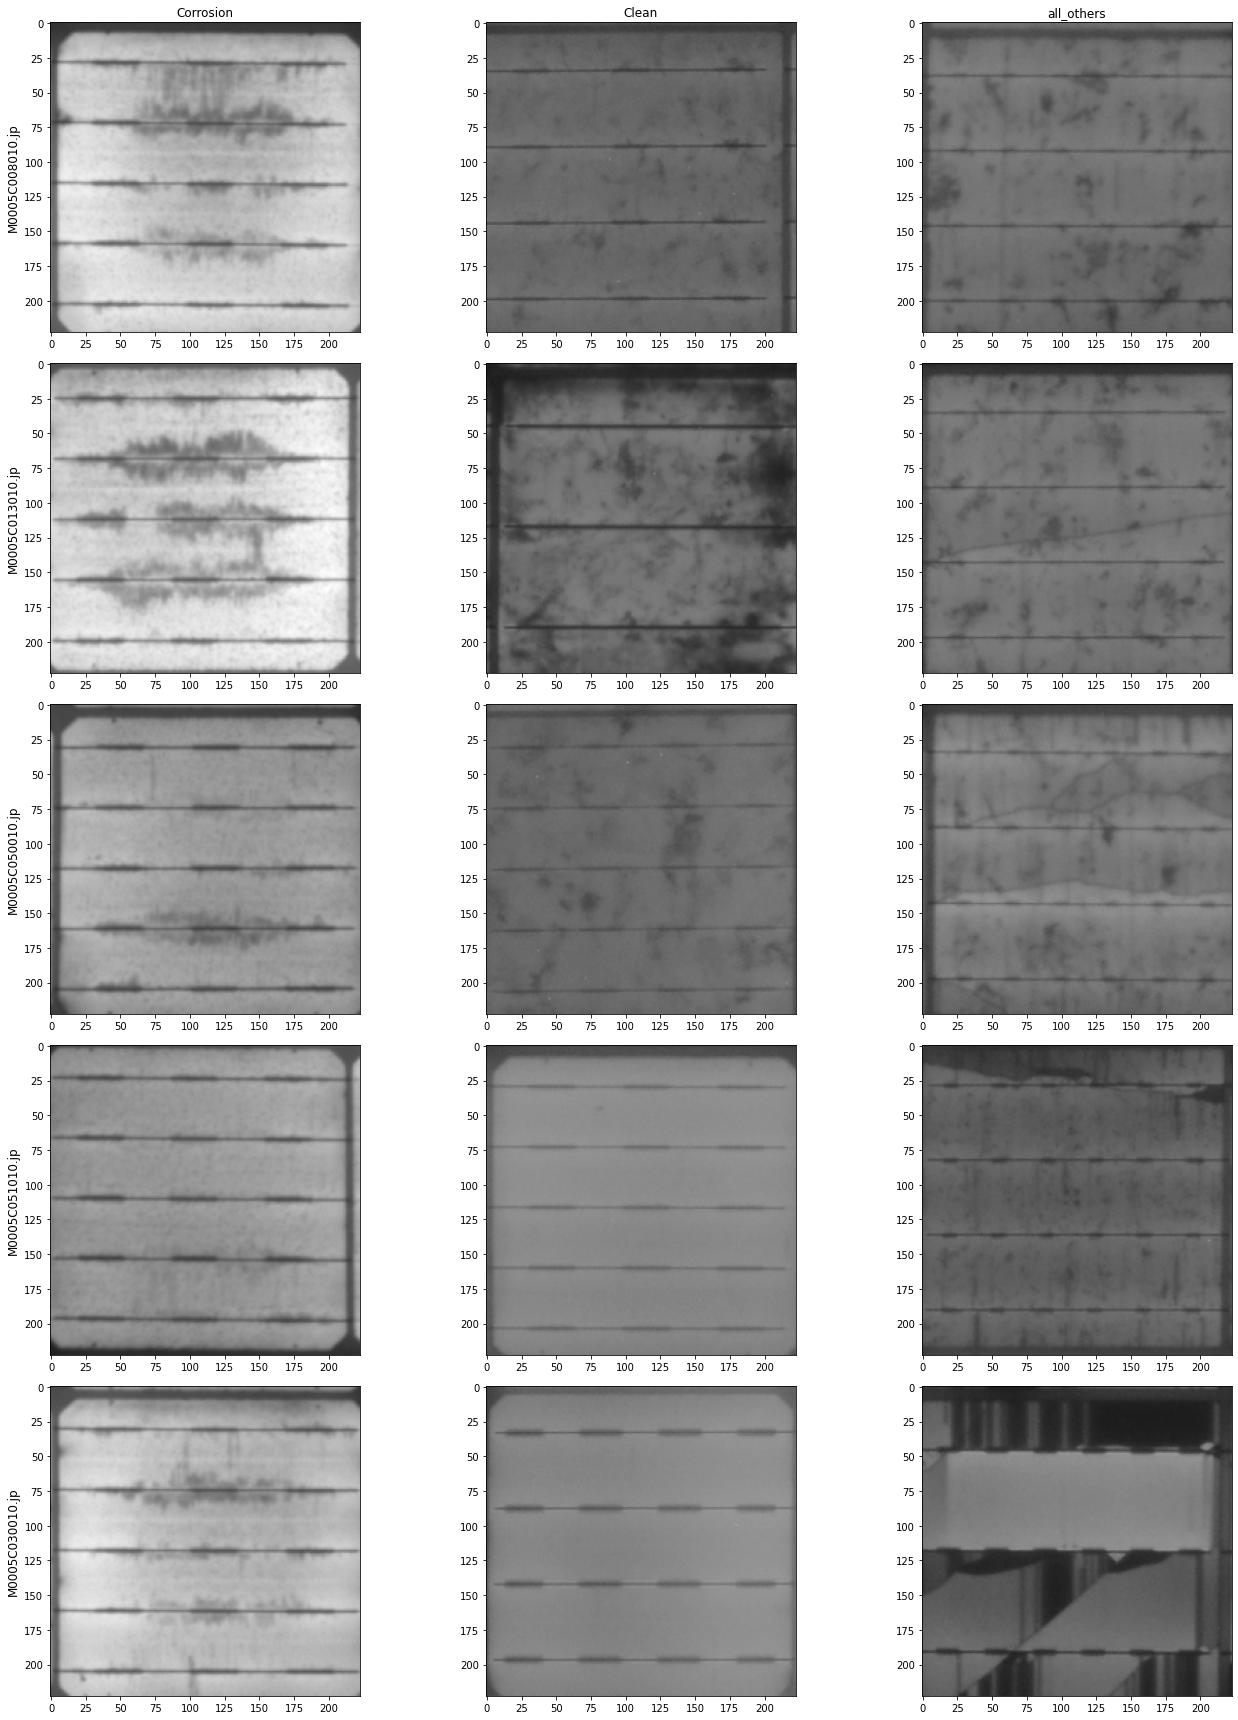

In [6]:
# Load 100 examples and name the category for it. Category is like a title for images
n_samples = 500
defect, clean, all_others =  get_n_samples(n_samples)
_ = Show(num_images=5, seed=seed) << (defect, clean, all_others)

## What does the mean Clean and Corrosion Image look like?

In [9]:
# Calculate the average of all images within each category. 
average_clean = np.mean(clean.images, axis=0)
average_corrosion = np.mean(defect.images, axis=0)

Average Clean Cell


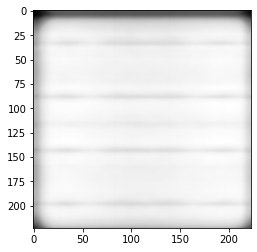

In [10]:
print('Average Clean Cell')
plt.imshow(average_clean, cmap='Greys_r')

Average Corroded Image


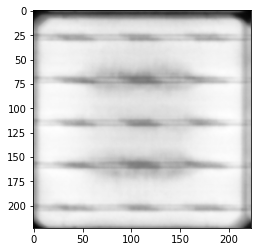

In [11]:
print('Average Corroded Image')
plt.imshow(average_corrosion, cmap='Greys_r')

## PCA on all images
### Analysis of principal components and variance 

20 principal components explain 93.63 % of the total variance


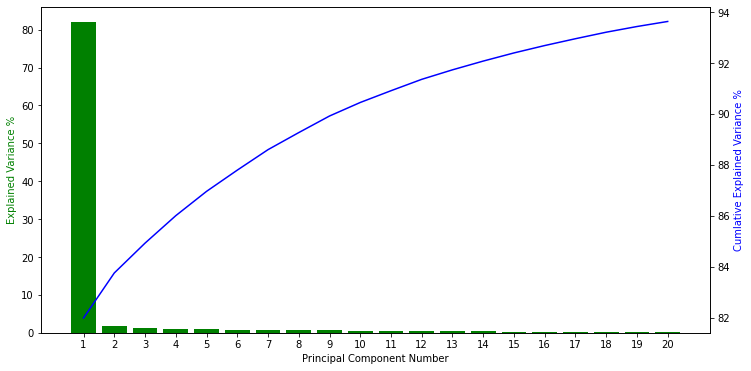

In [12]:
# Instantiate class
n =20
PCA_class_all_others = PCA(transpose=True, n_components=n, whiten=True)

# Claculate the transform on the images
PCA_class_all_others << clean

# Total explained Variance
exp_var = PCA_class_all_others.explained_variance_ratio[0]
total_exp_var = np.sum(exp_var)
print(f'{n} principal components explain {total_exp_var * 100:.2f} % of the total variance')

# Plot 
variance_plot(exp_var, n)

20 principal components explain 98.71 % of the total variance


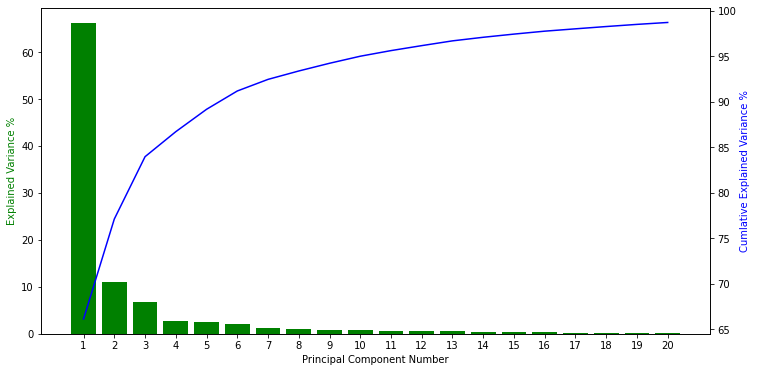

In [13]:
# Instantiate class
n = 20
PCA_class_defect = PCA(transpose=True, n_components=n, whiten=True)

# Claculate the transform on the images
PCA_class_defect << defect

# Total explained Variance
exp_var = PCA_class_defect.explained_variance_ratio[0]
total_exp_var = np.sum(exp_var)
print(f'{n} principal components explain {total_exp_var * 100:.2f} % of the total variance')

# Plot 
variance_plot(exp_var, n)

### Let's view the Eigenfaces of each

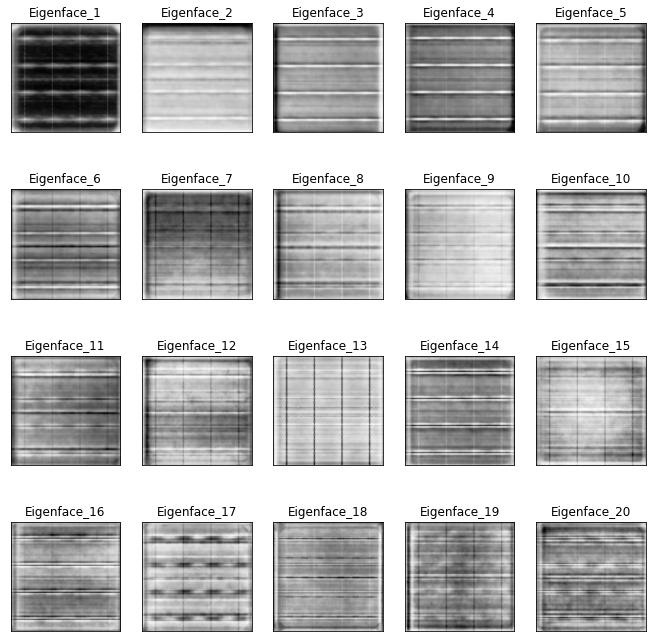

In [14]:
## Clean images
plot_gallery(PCA_class_all_others.eigenfaces[0])

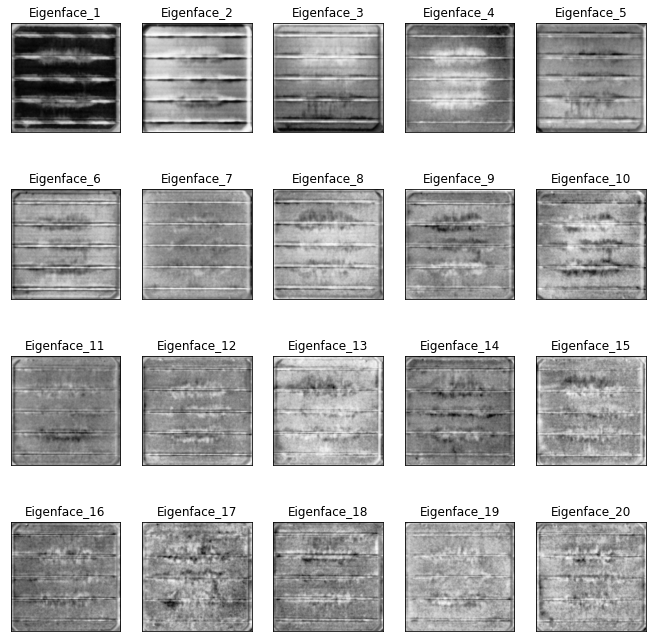

In [15]:
## Defected images
plot_gallery(PCA_class_defect.eigenfaces[0])

In [16]:
def get_cosine_similarity(template, img_array):
    """ Returns the cosine similarity of the top N eigenfaces.""" 
    
    #Get dims
    N, H, W = img_array.images.shape
    #Reshape images
    reshaped = img_array.images.reshape(N, H * W)
    # Reshape template
    stacked_face = template.reshape(len(template), H*W)
    # Calculate similarity
    sim = cosine_similarity(stacked_face, reshaped)
    
    return sim

In [18]:
# Calculate the Cosine similarity of each of the clean/defect/all_others vs the eigenfaces.
eigenfaces = PCA_class_defect.eigenfaces[0]
sim_scores_clean = get_cosine_similarity(eigenfaces, clean)
sim_scores_defect = get_cosine_similarity(eigenfaces, defect)
sim_scores_all_others = get_cosine_similarity(eigenfaces, all_others)


-454.0546602422442
-30.93831862972887


In [26]:
## Inspect the data
score_list = [sim_scores_clean, sim_scores_defect, sim_scores_all_others]

for score in score_list:
    print(score.shape)

(20, 500)
(20, 31)
(20, 500)


We have the issue here that we have a very imbalanced dataset - we have 500 instances of clean and all other images, but only 31 instances of corroded cells. We will need to take this into account during classifier development. 

In [67]:
# Build some datasets

# Create label vector
labels = ['clean' for x in range(sim_scores_clean.shape[1])] \
            + ['corrosion' for x in range(sim_scores_defect.shape[1])] \
                + ['all_others' for x in range(sim_scores_all_others.shape[1])]
len(labels)

1031

In [71]:
# Create one feature vector
from sklearn.preprocessing import StandardScaler
sim_scores_combined = np.concatenate((sim_scores_clean, sim_scores_defect, sim_scores_all_others), axis=1).T

# Scale imnputs
scaler = StandardScaler()
# Filter into clean and all others comparisons
scaled_sim_scores_clean = scaler.fit_transform(sim_scores_combined[:531,:] )
scaled_sim_scores_all_others = scaler.fit_transform(sim_scores_combined[500:,:] )

In [72]:
# Let's view the PCA transformation
# We do it manually here since our image vector is of different shape than usually expected by the imager class. 
from sklearn.decomposition import PCA as SKPCA

# W
pca_ex = SKPCA(n_components = 2, whiten='True')
X_clean = pca_ex.fit_transform(scaled_sim_scores)

pca_ex = SKPCA(n_components = 2, whiten='True')
X_all_others = pca_ex.fit_transform(scaled_sim_scores)

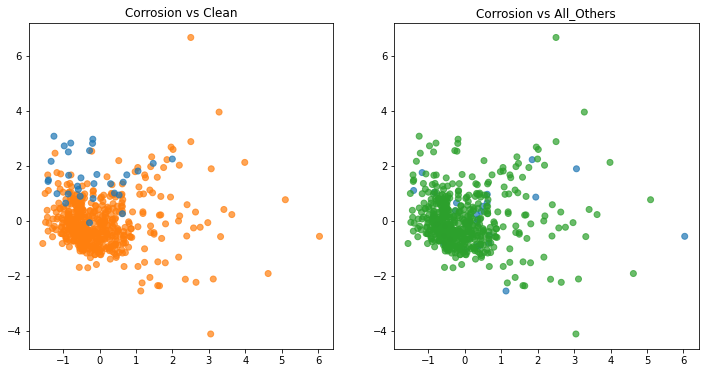

In [76]:
from matplotlib.lines import Line2D
import pandas as pd

clean_df = pd.DataFrame({'label':labels[:531]})
all_others_df = pd.DataFrame({'label':labels[500:]})

colors = {'corrosion':'tab:blue', 'clean':'tab:orange', 'all_others':'tab:green'}

fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(12, 6))
axs[0].scatter(X_clean[:,0], X_clean[:,1], c=clean_df['label'].map(colors), alpha=0.7)
axs[0].set_title('Corrosion vs Clean')

axs[1].scatter(X_clean[:,0], X_clean[:,1], c=all_others_df['label'].map(colors), alpha=0.7)
axs[1].set_title('Corrosion vs All_Others')
plt.show()

In the previous code, we calcualted the cosine similarity between each image and the first 20 eigen faces of the corrosion dataset. We then created a 1x20 vector for each image and performed PCA on those images to see if there was linear separation in the data. From the above plot, there does not appear to be good clustering. 

In the next step we treat the cosine similarity between each of the 20 eigenfaces and the image as a feature vector and evaluate a classifier. 

### Base Logistic Regression Model - no transforms

In [98]:
# base- single defect vs. clean
title = 'Base Model single defect vs. clean'
model_params = {'penalty': 'l2', 'seed': 4156, 'pca_dims': None, 'max_iter':500}
cla = Classifier(defect, clean, LogisticRegression, None)
score = cla.fit_cv(**model_params)
print("Score for:", title, " ", score, "\n")

Score for: Base Model single defect vs. clean   1.0 



In [129]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

# Create some datasets  - vs clean
data = np.concatenate((sim_scores_defect,sim_scores_clean), axis=1)
data_clean = data.T
defect_label = np.ones(sim_scores_defect[0].shape)
clean_label = np.zeros(sim_scores_clean[0].shape)
labels_clean = np.concatenate((defect_label,clean_label),axis=0)

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
            data_clean, labels_clean, test_size=0.15, random_state=42)

# Create some datasets - vs all others. 
data = np.concatenate((sim_scores_defect,sim_scores_all_others), axis=1)
data_ao = data.T
defect_label = np.ones(sim_scores_defect[0].shape)
clean_label = np.zeros(sim_scores_all_others[0].shape)
labels_ao = np.concatenate((defect_label,clean_label),axis=0)

X_train_all_others, X_test_all_others, y_train_all_others, y_test_all_others = train_test_split(
            data_ao, labels_ao, test_size=0.15, random_state=42)

In [130]:
title = 'Cosine Similarity PCA 0 single defect vs. clean'
clf = LogisticRegression(random_state=0).fit(X_train_clean, y=y_train_clean)
score = clf.score(X_test_clean, y_test_clean)
print(f"Score for: {title}: {score:.6f}")

Score for: Cosine Similarity PCA 0 single defect vs. clean: 0.925000


In [131]:
title = 'Cosine Similarity PCA 0 single defect vs. all_others'
clf = LogisticRegression(random_state=0).fit(X_train_all_others, y=y_train_all_others)
X_preds = clf.predict(X_test_all_others)
score = clf.score(X_test_all_others, y_test_all_others)
print(f"Score for: {title}: {score:.6f}")

Score for: Cosine Similarity PCA 0 single defect vs. all_others: 0.925000


In [132]:
X_preds

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

There is a potential issue here in that due to the imbalance in the data, we are unable to properly train the model. We noted that the model is consistentpy predicting the dominant class (0) as per the output above. 